In [35]:
import networkx as nx
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from torch.distributions import Normal
import pandas as pd
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, leaves_list
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.cluster.hierarchy import fcluster
from sklearn.manifold import MDS
from matplotlib.colors import BoundaryNorm

from model import LDM

In [52]:
class create_plots:
    def __init__(self, Aij, links, drug_emb, effect_emb, dim_reduction = "defualt", seed = None):
        self.Aij = Aij.detach().cpu().numpy()
        self.links = links.detach().cpu().numpy()
        self.drug_emb = drug_emb.detach().cpu().numpy()
        self.effect_emb = effect_emb.detach().cpu().numpy()
        self.dim_reduction = dim_reduction.lower()

        self.n_drugs = self.drug_emb.shape[0]
        self.n_effects = self.effect_emb.shape[0]

        self.seed = seed
        self.__set_seed(seed)

    def __set_seed(self, seed):
        if seed is not None:
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)

    def create_network(self):
        G = nx.Graph()

        for i in range(self.n_drugs):
            G.add_node(f"Drug_{i}", bipartite=0)
        for j in range(self.n_effects):
            G.add_node(f"Effect_{j}", bipartite=1)

        for i in range(self.n_drugs):
            for j in range(self.n_effects):
                if self.links[i,j] != 0:  
                    G.add_edge(f"Drug_{i}", f"Effect_{j}", weight=self.links[i,j])
        
        return G
    
    def reduce_dimensionality(self):
        """Reduce dimensionality using either the first two components or t-SNE."""
        if self.dim_reduction == "tsne":
            tsne = TSNE(n_components=2, perplexity=(self.n_drugs-1), random_state=self.seed)
            drugs_2d = tsne.fit_transform(self.drug_emb)
            effects_2d = tsne.fit_transform(self.effect_emb)
            return drugs_2d, effects_2d
        
        elif self.dim_reduction == "MDS":
            mds = MDS(n_components=2, random_state=self.seed)
            # drugs_2d = mds.fit_transform(self.drug_emb)
            # effects_2d = mds.fit_transform(self.effect_emb)
            all_emb = np.vstack([self.drug_emb, self.effect_emb])
            
            # Apply MDS to combined data
            all_2d = mds.fit_transform(all_emb)
            
            # Split the reduced embeddings
            n_drugs = self.drug_emb.shape[0]
            drugs_2d = all_2d[:n_drugs]
            effects_2d = all_2d[n_drugs:]
            return drugs_2d, effects_2d

        
        elif self.dim_reduction == "pca":
            pca = PCA(n_components=2)
            drugs_2d = pca.fit_transform(self.drug_emb)
            effects_2d = pca.fit_transform(self.effect_emb)
            return drugs_2d, effects_2d
        
        elif self.dim_reduction == "default":
            drugs_2d = self.drug_emb[:, :2]
            effects_2d = self.effect_emb[:,:2]
            return drugs_2d, effects_2d
        else: 
            drugs_2d = self.drug_emb[:, :2]
            effects_2d = self.effect_emb[:,:2]
            return drugs_2d, effects_2d
    
    def tsne_plot(self):
        drugs_2d, effects_2d = self.reduce_dimensionality()

        drug_linkage = linkage(self.drug_emb, method='ward')
        effect_linkage = linkage(self.effect_emb, method='ward')
        drug_clusters = fcluster(drug_linkage, t=4, criterion='maxclust')
        effect_clusters = fcluster(effect_linkage, t=4, criterion='maxclust')
        
        drug_colors = [cm.tab10(i % 10) for i in drug_clusters]
        effect_colors = [cm.Set2(i % 8) for i in effect_clusters]

        plt.figure(figsize=(10, 6))
        plt.scatter(drugs_2d[:, 0], drugs_2d[:, 1], label="Drugs", color='blue', alpha=0.6)
        plt.scatter(effects_2d[:, 0], effects_2d[:, 1], label="Side Effects", color='red', alpha=0.6)

        plt.legend()
        plt.title("t-SNE Representation of Drug and Side Effect Embeddings")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.grid(True)
        plt.show()
        return drugs_2d, effects_2d
    


    def tsne_plot2(self):
        drugs_2d, effects_2d = self.reduce_dimensionality()
        
        # Perform hierarchical clustering
        drug_linkage = linkage(self.drug_emb, method='ward')
        effect_linkage = linkage(self.effect_emb, method='ward')

        # Assign clusters
        drug_clusters = fcluster(drug_linkage, t=4, criterion='maxclust')
        effect_clusters = fcluster(effect_linkage, t=4, criterion='maxclust')

        # Assign colors by cluster
        drug_colors = [cm.tab10(i % 10) for i in drug_clusters]
        effect_colors = [cm.Set2(i % 8) for i in effect_clusters]

        plt.figure(figsize=(10, 6))

        # Use cluster-based colors instead of fixed colors
        plt.scatter(drugs_2d[:, 0], drugs_2d[:, 1], label="Drugs", c=drug_colors, alpha=0.6, edgecolor='k')
        #plt.scatter(effects_2d[:, 0], effects_2d[:, 1], label="Side Effects", c=effect_colors, alpha=0.6, marker='^', edgecolor='k')

        plt.legend()
        plt.title("t-SNE Representation of Drug and Side Effect Embeddings")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.xlim(1e-6*2.025, 1e-6*2.1)
        plt.ylim(1e-7*4.05, 1e-7*4.65)
        plt.grid(True)
        plt.show()

        return drugs_2d, effects_2d

    def tsne_plot2(self):
        drugs_2d, effects_2d = self.reduce_dimensionality()
        
        # Perform hierarchical clustering
        drug_linkage = linkage(self.drug_emb, method='ward')
        effect_linkage = linkage(self.effect_emb, method='ward')

        # Assign clusters
        drug_clusters = fcluster(drug_linkage, t=9, criterion='maxclust')
        effect_clusters = fcluster(effect_linkage, t=5, criterion='maxclust')

        # Assign colors by cluster
        drug_colors = [cm.tab10(i % 10) for i in drug_clusters]
        effect_colors = [cm.Set2(i % 8) for i in effect_clusters]

        plt.figure(figsize=(20, 15))

        # Use cluster-based colors instead of fixed colors
        plt.scatter(drugs_2d[:, 0], drugs_2d[:, 1], label="Drugs", c=drug_colors)
        #plt.scatter(effects_2d[:, 0], effects_2d[:, 1], label="Side Effects", c=effect_colors, alpha=0.6, marker='^', edgecolor='k')

        plt.legend()
        plt.title("t-SNE Representation of Drug and Side Effect Embeddings")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.xlim(1e-6*2.025, 1e-6*2.1)
        plt.ylim(1e-7*4, 1e-7*4.7)
        plt.grid(True)
        plt.show()

        return drugs_2d, effects_2d

    def links_space(self):
        G = self.create_network()
        drugs_2d, effects_2d = self.reduce_dimensionality()
        pos = {}
        for i in range(self.n_drugs):
            pos[f"Drug_{i}"] = (drugs_2d[i, 0], drugs_2d[i, 1])  # 2D position based on first two embedding dims
        
        # Position effects based on their embeddings
        for j in range(self.n_effects):
            pos[f"Effect_{j}"] = (effects_2d[j, 0], effects_2d[j, 1])

        # Draw the graph
        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, with_labels=False, node_size=10, node_color=["skyblue" if "Drug" in node else "lightgreen" for node in G.nodes], font_size=10, font_weight='bold', edge_color='gray')

        # Display edge weights (probabilities) as labels
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

        plt.title('Drug-Side Effect Network based on Embeddings and Probit Output')
        plt.show()

    def links_space_clustered(self):
        G = self.create_network()
        drugs_2d, effects_2d = self.reduce_dimensionality()
        
        # Dendrogram clustering for coloring
        drug_linkage = linkage(self.drug_emb, method='ward')
        effect_linkage = linkage(self.effect_emb, method='ward')
        drug_clusters = fcluster(drug_linkage, t=9, criterion='maxclust')
        effect_clusters = fcluster(effect_linkage, t=9, criterion='maxclust')
        
        drug_colors = [cm.tab10(i % 10) for i in drug_clusters]
        effect_colors = [cm.Set2(i % 8) for i in effect_clusters]

        # Positions
        pos = {}
        for i in range(self.n_drugs):
            pos[f"Drug_{i}"] = (drugs_2d[i, 0], drugs_2d[i, 1])
        for j in range(self.n_effects):
            pos[f"Effect_{j}"] = (effects_2d[j, 0], effects_2d[j, 1])

        # Assign cluster-based node colors
        node_colors = []
        for node in G.nodes:
            if "Drug" in node:
                idx = int(node.split("_")[1])
                node_colors.append(drug_colors[idx])
            else:
                idx = int(node.split("_")[1])
                node_colors.append(effect_colors[idx])

        # Plot
        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, with_labels=False, node_size=100, node_color=node_colors,
                font_size=10, font_weight='bold', edge_color='gray')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'))

        plt.title('Drug-Side Effect Network Colored by Dendrogram Clusters')
        plt.show()
    def links_space_clustered_radial(self):
        # Stack embeddings
        all_emb = np.vstack([self.drug_emb, self.effect_emb])

        # Joint dimensionality reduction
        mds = MDS(n_components=2, random_state=self.seed)
        all_2d = mds.fit_transform(all_emb)

        # Unified clustering
        linkage_all = linkage(all_emb, method='ward')
        clusters = fcluster(linkage_all, t=9, criterion='maxclust')

        # Split embeddings
        n_drugs = self.n_drugs
        drugs_2d = all_2d[:n_drugs]
        effects_2d = all_2d[n_drugs:]
        drug_clusters = clusters[:n_drugs]
        effect_clusters = clusters[n_drugs:]

        # Plot with distinct markers and transparency
        plt.figure(figsize=(10, 10))

        # Drugs: circles
        for i in range(1, np.max(clusters) + 1):
            mask = (drug_clusters == i)
            plt.scatter(drugs_2d[mask, 0], drugs_2d[mask, 1], 
                        label=f'Drug Cluster {i}', alpha=0.6, s=10)

        # Effects: triangles (lighter)
        # for i in range(1, np.max(clusters) + 1):
        #     mask = (effect_clusters == i)
        #     plt.scatter(effects_2d[mask, 0], effects_2d[mask, 1], 
        #                 marker='^', label=f'Effect Cluster {i}', alpha=0.4, s=10)

        plt.legend(markerscale=2)
        plt.title("Embedding Space with Joint Clustering (LDM/HBDM-style)")
        plt.grid(True)
        plt.show()


    
    def simple_links(self):
        G = self.create_network()

        pos = {}
        pos.update((node, (1, index)) for index, node in enumerate(f"Drug_{i}" for i in range(self.n_drugs)))  # Position for drugs
        pos.update((node, (2, index)) for index, node in enumerate(f"Effect_{j}" for j in range(self.n_effects)))  # Position for effects

        # Draw the graph
        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, with_labels=True, node_size=500, node_color=["skyblue" if "Drug" in node else "lightgreen" for node in G.nodes], font_size=10, font_weight='bold', edge_color='gray')

        # Display edge weights (optional)
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

        plt.title('Drug-Side Effect Network')
        plt.show()

    def dendrograms(self):
        drug_distance_matrix = squareform(pdist(self.drug_emb, metric="euclidean"))
        effect_distance_matrix = squareform(pdist(self.effect_emb, metric="euclidean"))
        
        drug_linkage = linkage(self.drug_emb, method='ward')
        effect_linkage = linkage(self.effect_emb, method='ward')

        plt.figure(figsize=(20, 10))
        dendrogram(drug_linkage, labels=[f"Drug {i}" for i in range(len(self.drug_emb))], leaf_rotation=90)
        plt.xlabel("Drugs")
        plt.ylabel("Distance")
        plt.title("Drug Hierarchical Clustering Dendrogram")
        plt.show()

        plt.figure(figsize=(20, 10))
        dendrogram(effect_linkage, labels=[f"SE {i}" for i in range(len(self.effect_emb))], leaf_rotation=90)
        plt.xlabel("Side Effects")
        plt.ylabel("Distance")
        plt.title("Side Effect Hierarchical Clustering Dendrogram")
        plt.show()

    def reorder_matrix(self):
        drug_distance_matrix = squareform(pdist(self.drug_emb, metric="euclidean"))
        effect_distance_matrix = squareform(pdist(self.effect_emb, metric="euclidean"))
        
        drug_linkage = linkage(self.drug_emb, method='ward')
        effect_linkage = linkage(self.effect_emb, method='ward')

        # Find new order
        drug_order = leaves_list(drug_linkage)
        effect_order = leaves_list(effect_linkage)

        Aij_reordered = self.Aij[drug_order, :][:, effect_order]

        drug_adj = self.Aij @ self.Aij.T  # Drug-drug adjacency
        effect_adj = self.Aij.T @ self.Aij  # Effect-effect adjacency

        drug_adj_reordered = drug_adj[drug_order, :][:, drug_order]
        effect_adj_reordered = effect_adj[effect_order, :][:, effect_order]
        return Aij_reordered, drug_adj_reordered, effect_adj_reordered, drug_adj, effect_adj
    
    def plot_reorder_Aij(self):
        Aij_reordered, drug_adj_reordered, effect_adj_reordered, drug_adj, effect_adj = self.reorder_matrix()
        print("Reordered Aij shape:", Aij_reordered.shape)
        print("Reordered Aij min/max:", Aij_reordered.min(), Aij_reordered.max())
        cmap = plt.cm.Oranges
        bounds = [0, 1, 2, 3, 4]
        norm = BoundaryNorm(bounds, cmap.N)
        plt.figure(figsize=(20,10))
        plt.subplot(1,2,1)
        plt.imshow(self.Aij, cmap=cmap, norm=norm, aspect='auto')
        plt.title("Original Aij")
        plt.xlabel("Side Effects")
        plt.ylabel("Drugs")
        plt.colorbar()

        plt.subplot(1,2,2)
        plt.imshow(Aij_reordered, cmap=cmap, norm=norm, aspect='auto')
        plt.title("Reordered Aij")
        plt.xlabel("Side Effects")
        plt.ylabel("Drugs")
        plt.colorbar()
        plt.tight_layout()
        plt.show()

    def plot_reorder(self):
        Aij_reordered, drug_adj_reordered, effect_adj_reordered, drug_adj, effect_adj = self.reorder_matrix()
        plt.figure(figsize=(20,20))
        plt.subplot(3,2,1)
        plt.imshow(self.Aij, aspect='auto', cmap='viridis')
        plt.title("Original Aij")
        plt.xlabel("Side Effects")
        plt.ylabel("Drugs")
        plt.colorbar()

        plt.subplot(3,2,2)
        plt.imshow(Aij_reordered, aspect='auto', cmap='viridis')
        plt.title("Reordered Aij")
        plt.xlabel("Side Effects")
        plt.ylabel("Drugs")
        plt.colorbar()

        plt.subplot(3,2,3)
        plt.imshow(drug_adj, aspect='auto', cmap='viridis')
        plt.title("Original Drug-adjacency matrix")
        plt.xlabel("Drugs")
        plt.ylabel("Drugs")
        plt.colorbar()

        plt.subplot(3,2,4)
        plt.imshow(drug_adj_reordered, aspect='auto', cmap='viridis')
        plt.title("Reordered Drug-adjacency matrix")
        plt.xlabel("Drugs")
        plt.ylabel("Drugs")
        plt.colorbar()

        plt.subplot(3,2,5)
        plt.imshow(effect_adj, aspect='auto', cmap='viridis')
        plt.title("Original Side Effect-adjacency matrix")
        plt.xlabel("Side Effects")
        plt.ylabel("Side Effects")
        plt.colorbar()

        plt.subplot(3,2,6)
        plt.imshow(effect_adj_reordered, aspect='auto', cmap='viridis')
        plt.title("Reordered Side Effect-adjacency matrix")
        plt.xlabel("Side Effects")
        plt.ylabel("Side Effects")
        plt.colorbar()
        plt.show()
        

In [8]:
def plot_loss(losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(losses)), losses, marker='o', linestyle='-', color='b')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Function During Training')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 17
Aij = torch.tensor([[0, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0], 
                    [0, 0, 2, 0, 1, 0, 3, 0, 0, 1, 0, 0],
                    [3, 3, 0, 0, 0, 1, 0, 3, 0, 0, 0, 1],
                    [3, 3, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0],
                    [0, 0, 2, 0, 0, 0, 3, 0, 1, 0, 0, 0],
                    [1, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0], 
                    [0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0],
                    [0, 3, 1, 0, 0, 1, 0, 3, 0, 0, 0, 1],
                    [3, 3, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2],
                    [0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0]],dtype=torch.float32, device=device) #column: side effect, row:drug, value: frequency (ordinal)
n_epochs = 500
lr = 0.01
seed = 20
model1 = LDM(Aij, embedding_dim, device, n_epochs, lr, seed)
probit_output1 = model1.probit()  # Compute the probit probability matrix
loss_out1 = model1.train()  # Compute the ordinal cross-entropy loss

In [49]:
links1, ordinal_vals1 = model1.predict_categories()
drug_emb1, effect_emb1 = model1.get_embeddings()

In [53]:
plots1 = create_plots(links1, Aij, drug_emb1, effect_emb1, dim_reduction="MDS", seed = 10)

Reordered Aij shape: (10, 12)
Reordered Aij min/max: 0 3


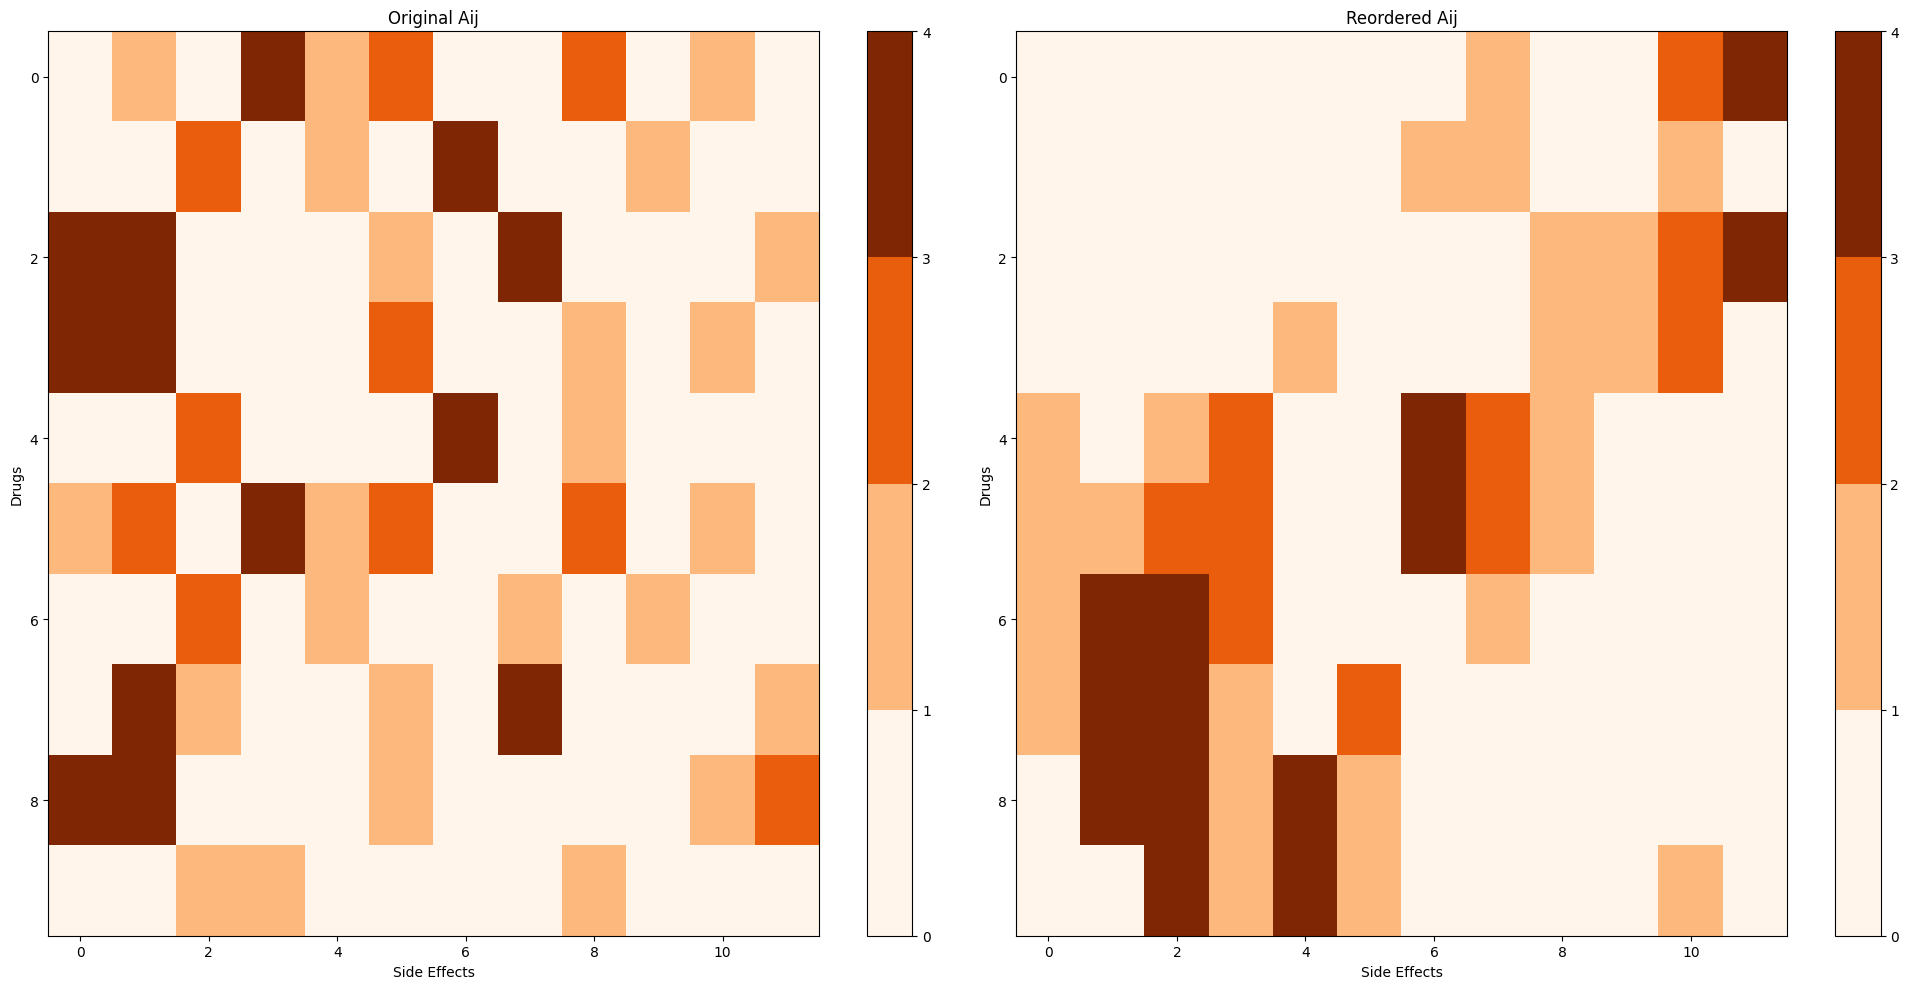

In [54]:
plots1.plot_reorder_Aij()

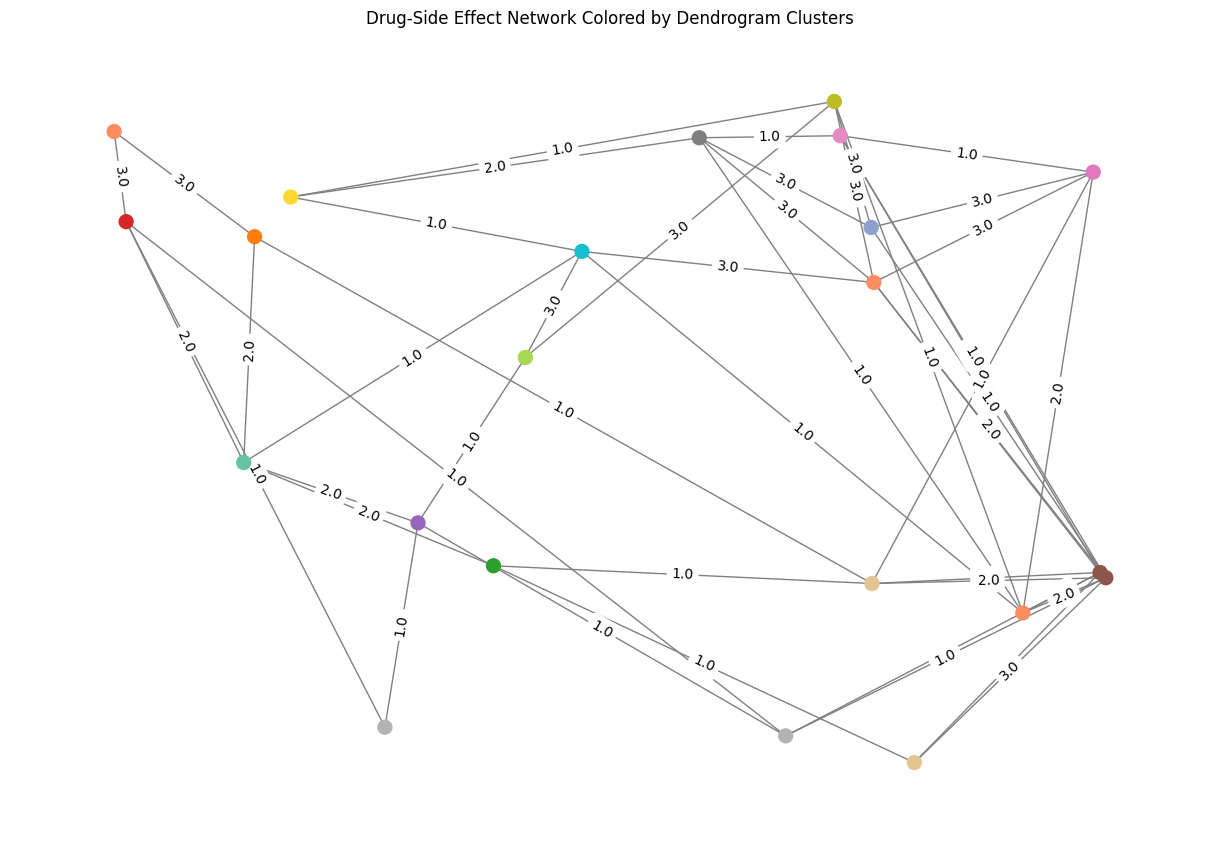

In [6]:
plots1.links_space_clustered()

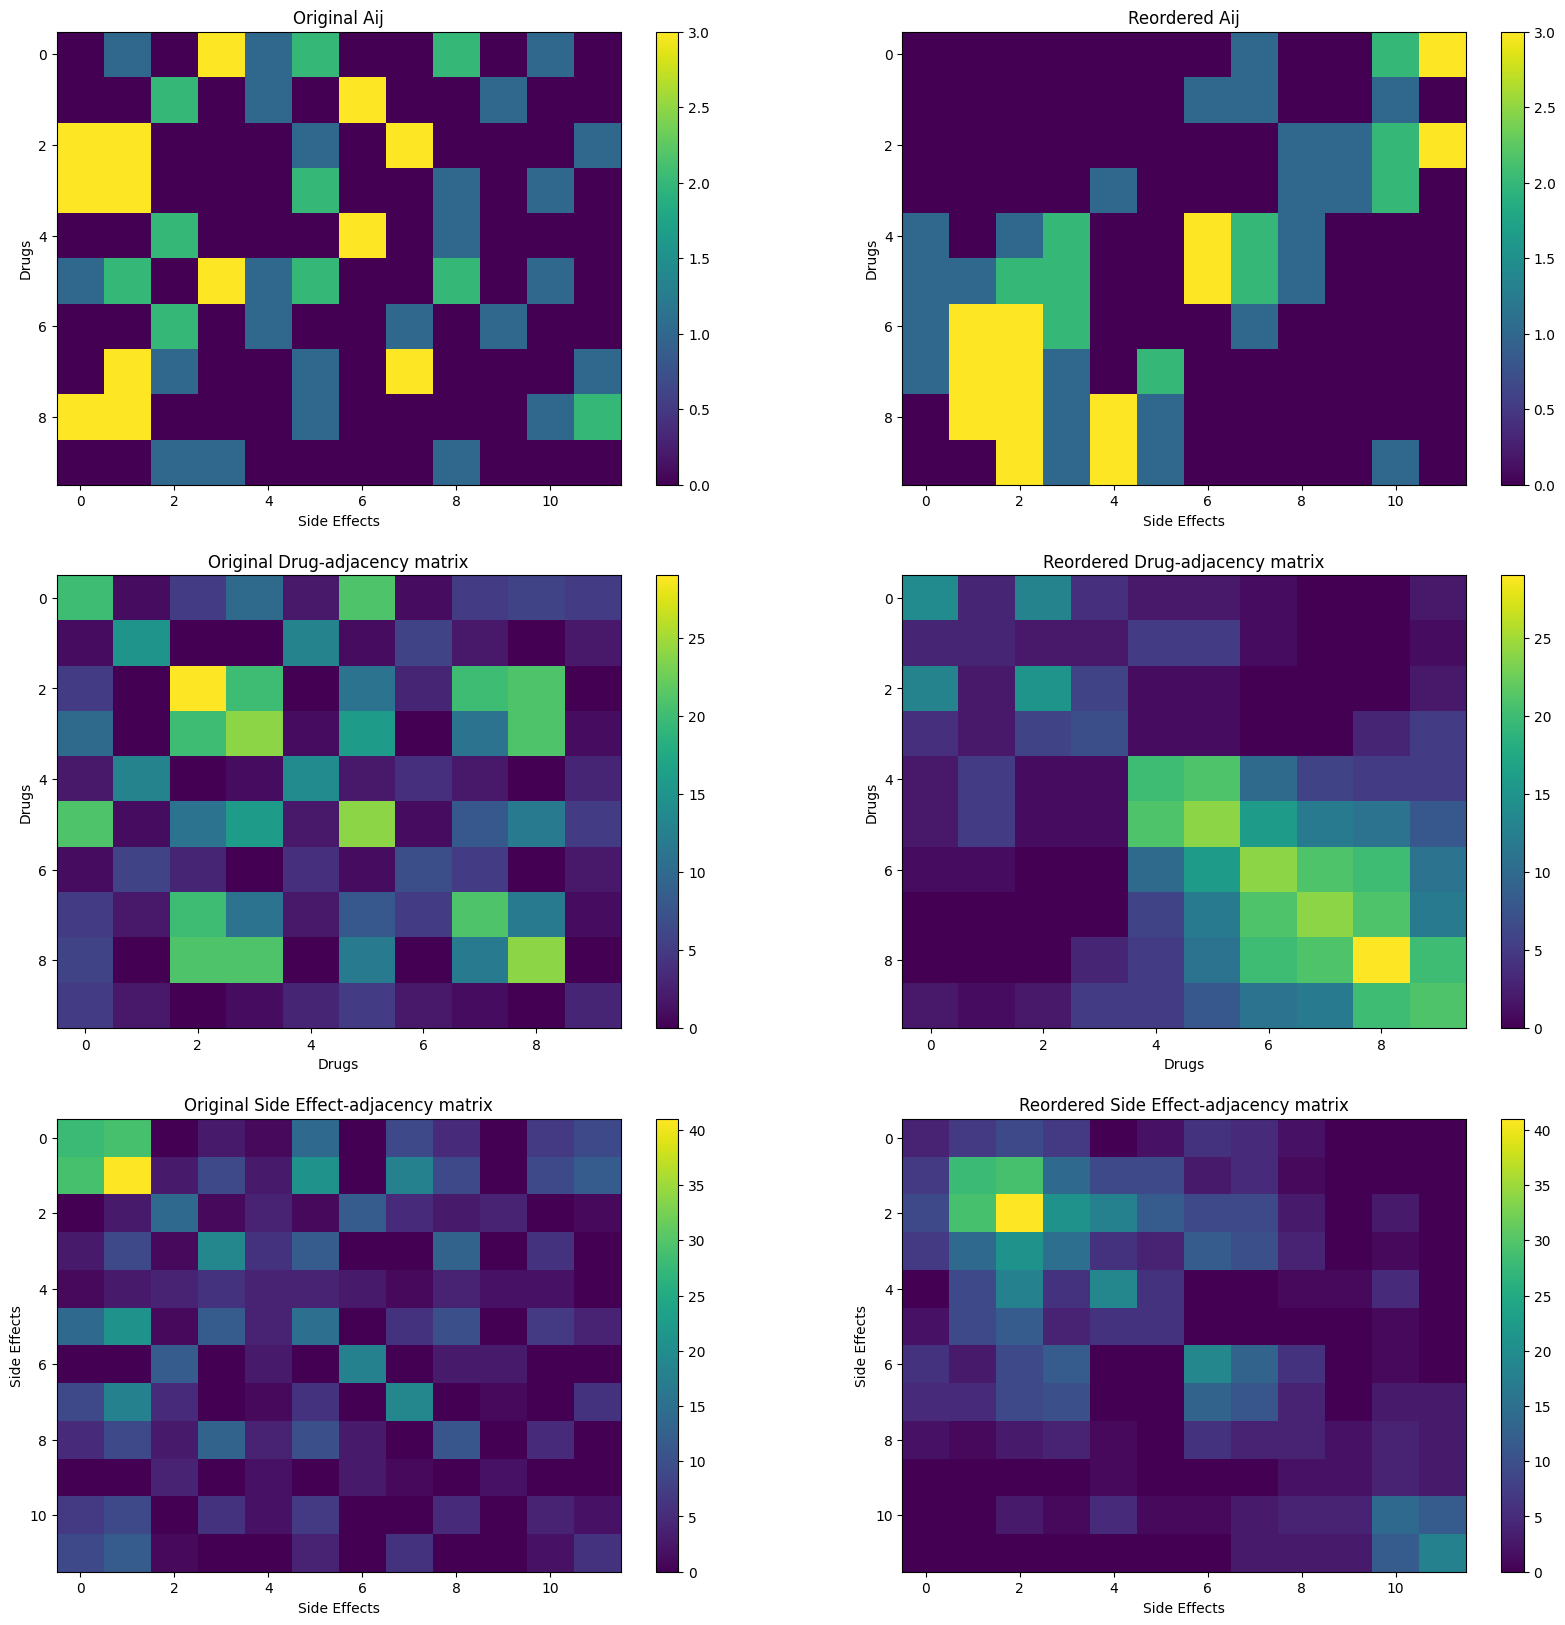

In [7]:
plots1.plot_reorder()

### real data

In [9]:
def load_data(path_to_csv, device):
    df = pd.read_csv(path_to_csv, index_col=0)
    Aij = torch.tensor(df.values, dtype=torch.float32).to(device)
    return Aij

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
csv_path = "/Users/christine/LatentDistanceModel/data/filtered_adj_matrix.csv" 
Aij_real = load_data(csv_path, device)
print(Aij_real.shape)

torch.Size([745, 3677])


In [10]:
embedding_dim = 500
n_epohs = 100
model = LDM(Aij_real, embedding_dim, device, n_epochs, lr, seed)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.train() 

In [11]:
links, ordinal_vals = model.predict_categories()
drug_emb, effect_emb = model.get_embeddings()

In [57]:
plots2 = create_plots(links, Aij_real, drug_emb, effect_emb, dim_reduction="MDS", seed = 10)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1100a1670>>
Traceback (most recent call last):
  File "/Users/christine/Library/Python/3.12/lib/python/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


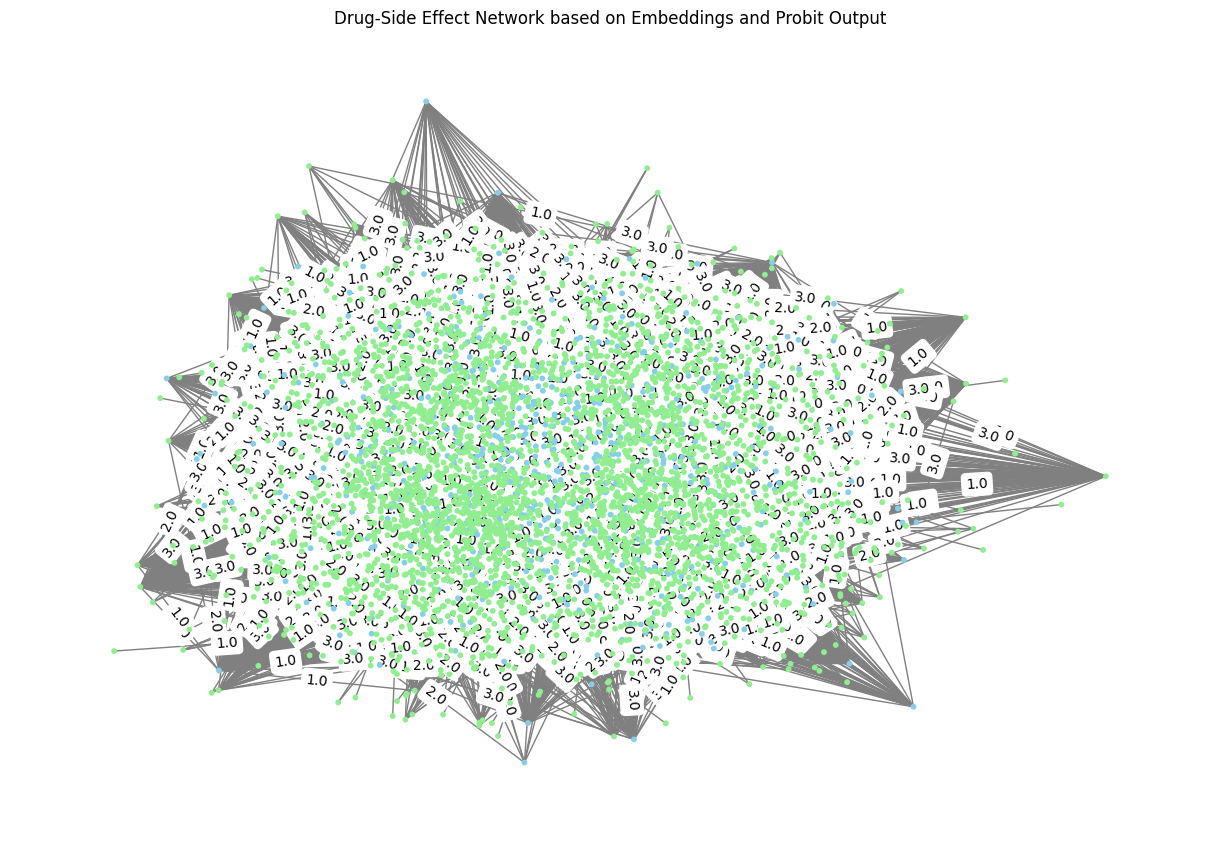

In [16]:
plots2.links_space()

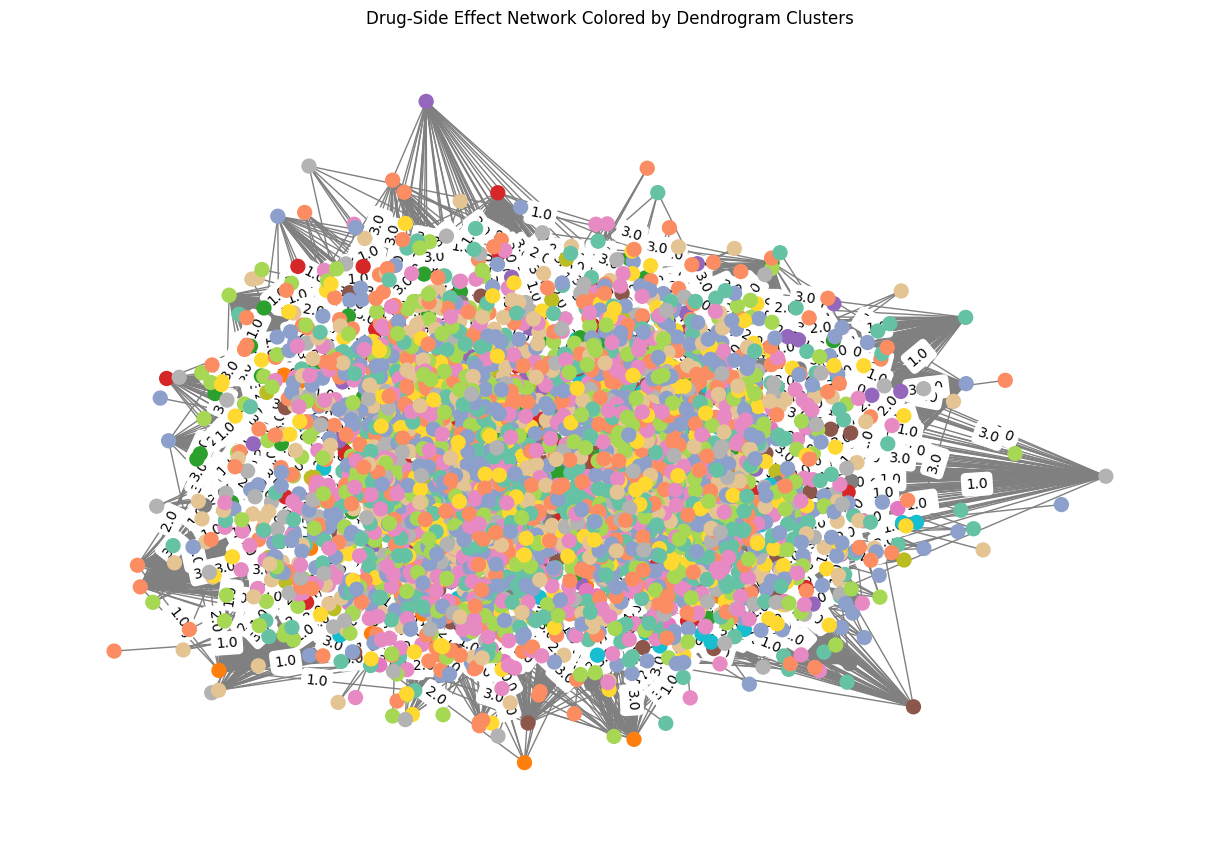

In [26]:
plots1.links_space_clustered()

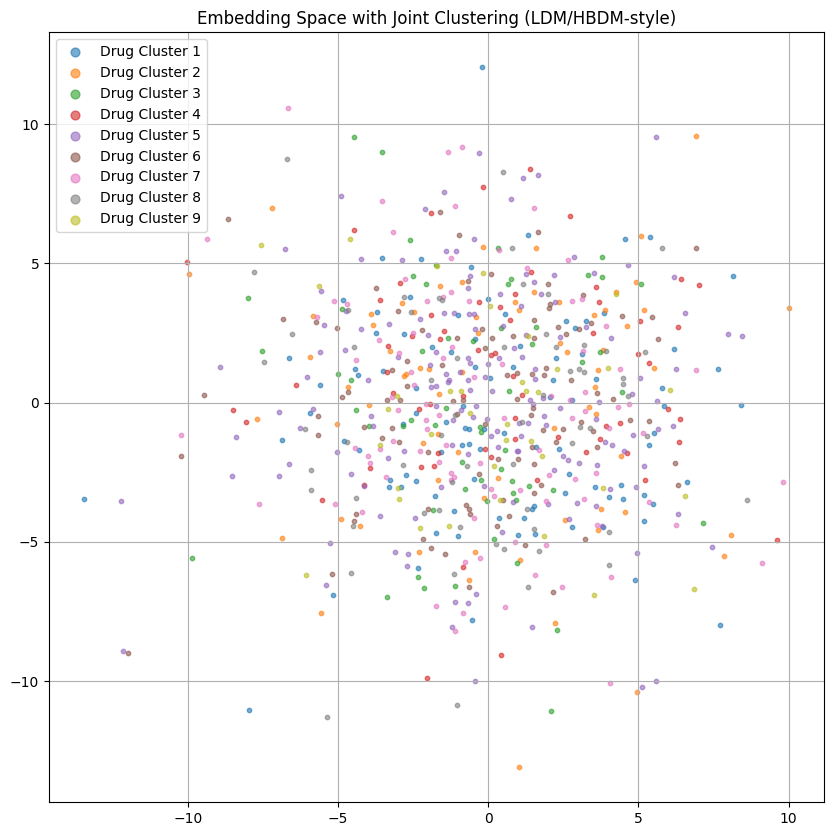

In [33]:
plots1.links_space_clustered_radial()

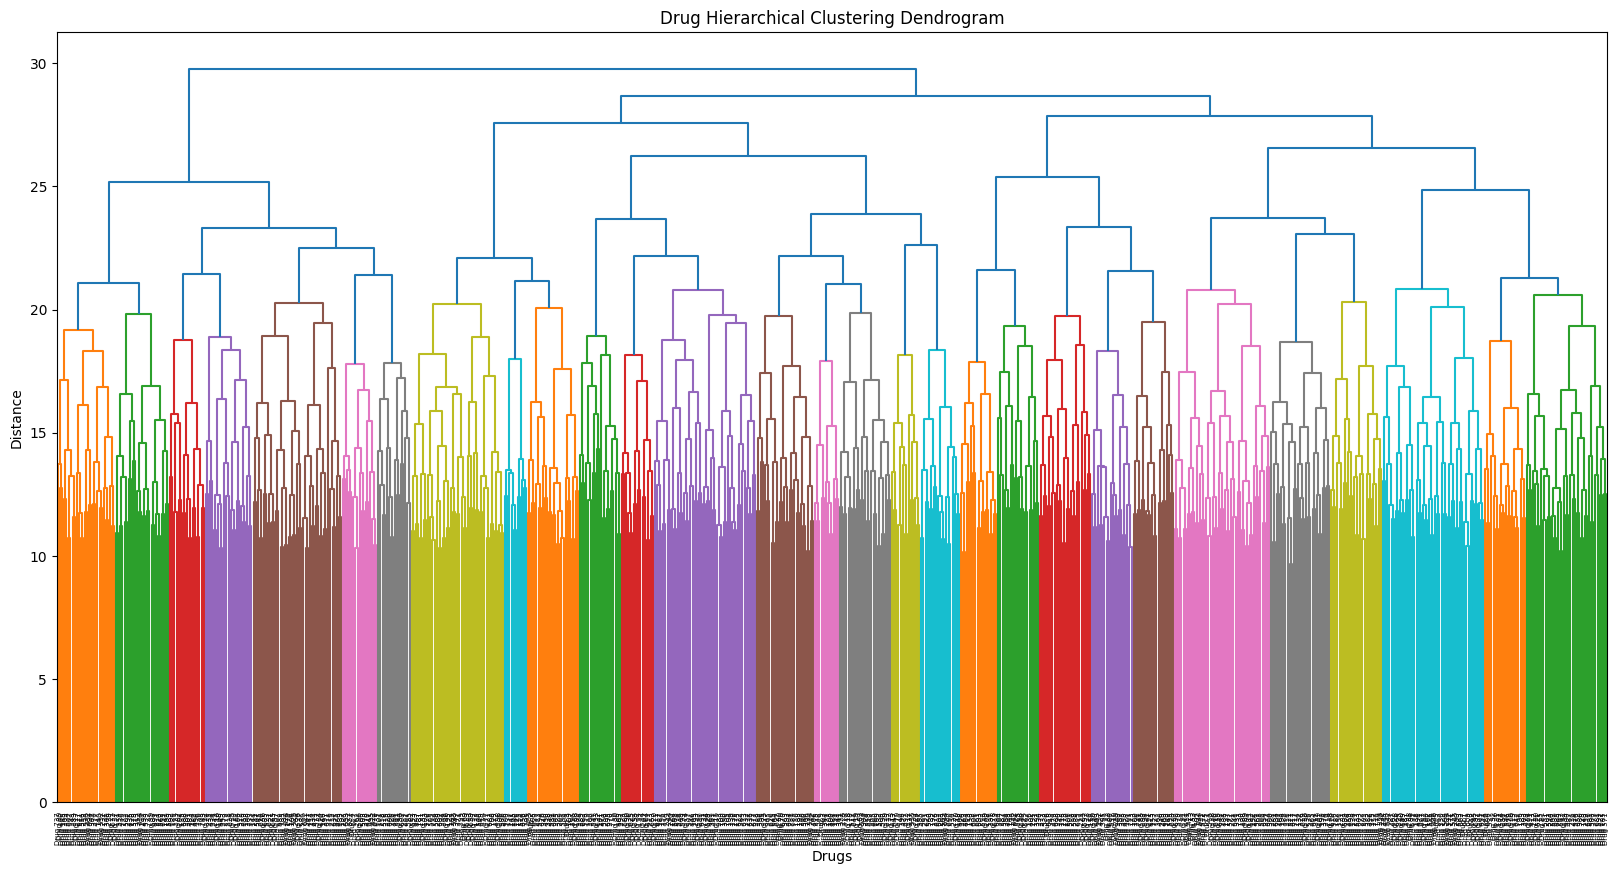

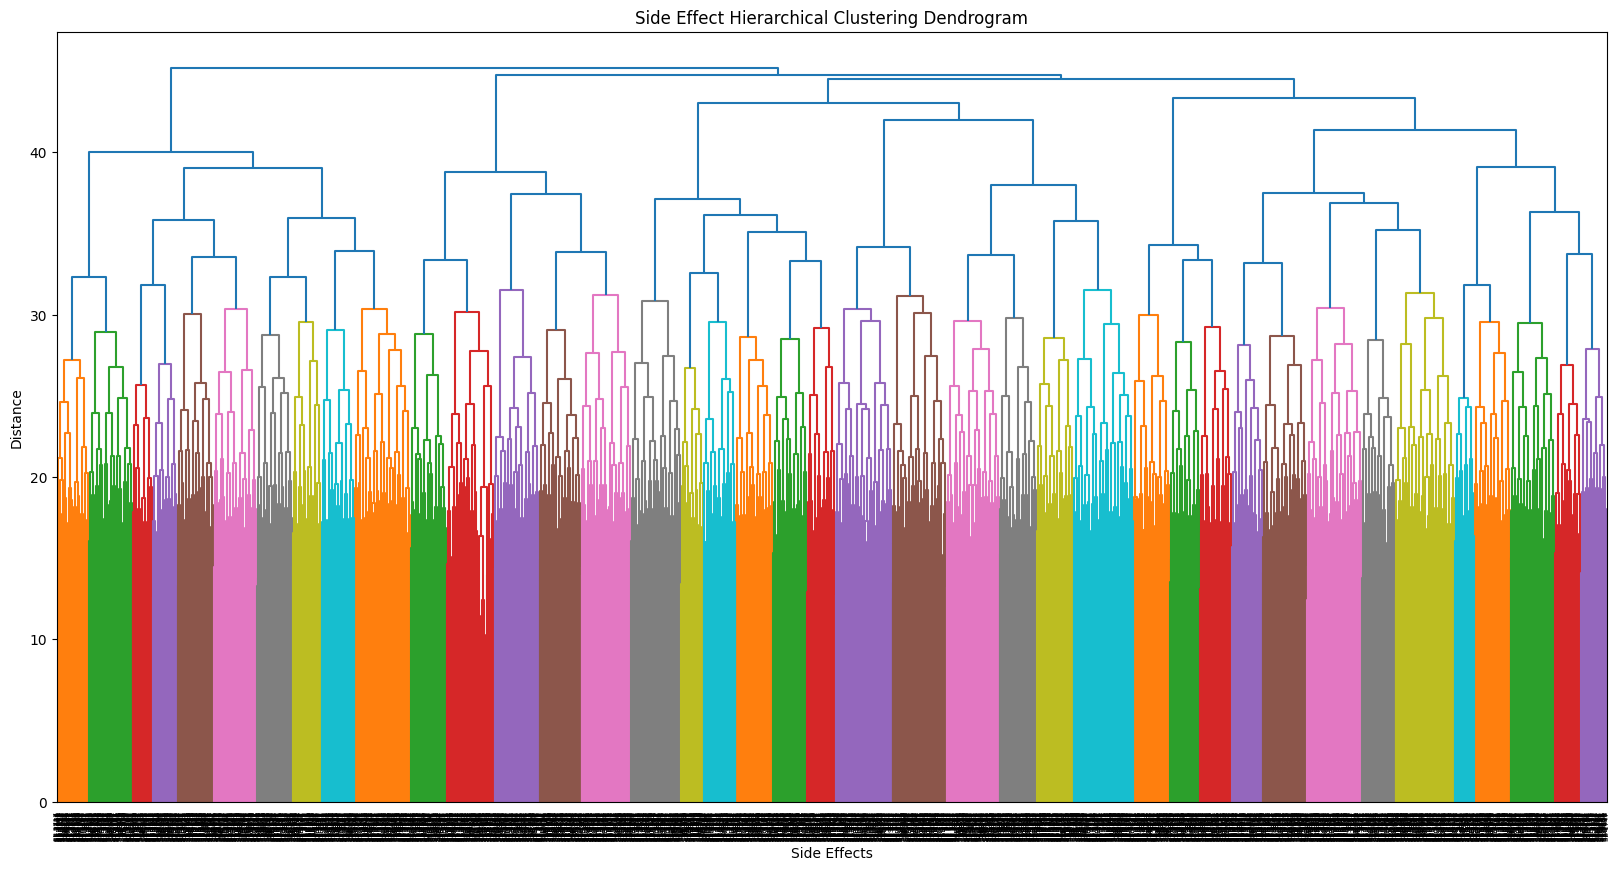

In [19]:
plots1.dendrograms()

Reordered Aij shape: (745, 3677)
Reordered Aij min/max: 0 0


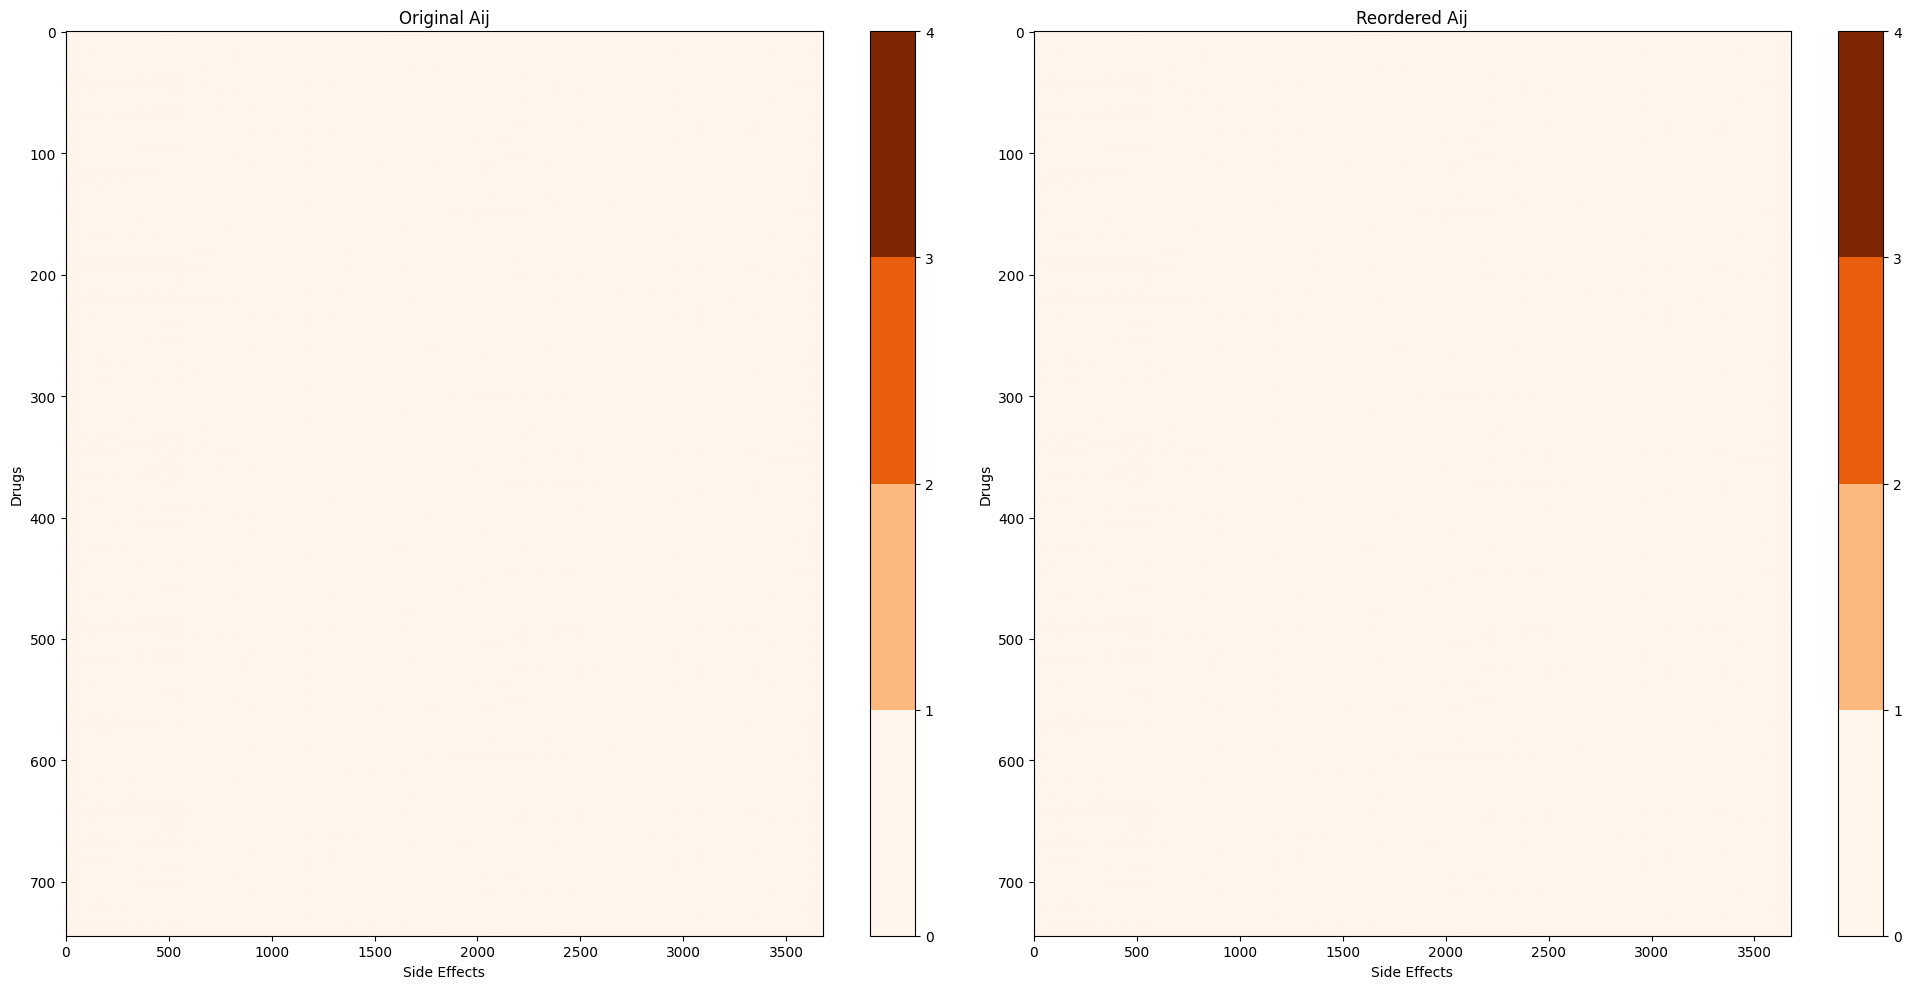

In [58]:
plots2.plot_reorder_Aij()

Fix multidimensional scaling, det skal concat drug og effects. Skal også redegøres for i rapport